# LeNet 5



In [1]:
from algorithms import *
from lenet5 import *
import numpy as np
import matplotlib.pyplot as plt

_, (test_x, test_y) = load_MNIST()

path = './data/lenet5'

lenet5 = LeNet5(path=path, load=True)

epsilon = 0.25
d = 28*28

lab = lenet5.predict(test_x)
indexes = lab == test_y
data = test_x[indexes]
labels = test_y[indexes]

print(len(labels))  # 9826

# M = num workers; we consider a number of workers <=10
M = 10
data_per_classes = []
for label_class in range(0, 10):
    data_per_classes.append(data[labels == label_class][:100])

data_per_classes = np.array(data_per_classes)
data_workers = []

for offset in range(0, 100, M):
    image_worker = []
    for c in range(0, 10):
        image_worker.extend(data_per_classes[c, offset:offset+M, :, :, :])
    data_workers.append(image_worker)

data_workers = np.array(data_workers)
print(data_workers.shape)  # now all 10 workers have 100 images, 10 for each class.

y = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
y = np.repeat(y, 10)


OSError: SavedModel file does not exist at: ./data/lenet5/{saved_model.pbtxt|saved_model.pb}

# Universal Adversarial Attacks

In [4]:
def plot_perturbation(perturbation, m):
  fig, ax = plt.subplots(figsize=(12, 12))
  img = plt.imshow(perturbation.reshape((28, 28)))
  fig.colorbar(img, ax=ax, fraction=0.03, pad=0.05)
  plt.savefig(f"./perturbation_{m}", bbox_inches="tight")
  plt.show()

def plot_perturbated_img(perturbation, m):
  image = test_x[5].numpy().reshape(28,28)
  img_noise = image + perturbation.reshape((28, 28))
  fig, ax = plt.subplots(1, 2,figsize=(5, 5))
  a = ax[0].imshow(image, cmap='Greys')
  b = ax[1].imshow(img_noise, cmap='Greys')
  fig.colorbar(a, ax=ax[0], fraction=0.03, pad=0.05)
  fig.colorbar(b, ax=ax[1], fraction=0.03, pad=0.05)
  plt.savefig(f"./image_perturbation_example_{m}", bbox_inches="tight")
  plt.show()

def plot_loss(loss_history, m):
  plt.figure(figsize=(10,6))
  plt.plot(m, loss_history[:, 0])
  plt.title('loss')

def plot_accuracy(loss_history, m):
  plt.figure(figsize=(10,6))
  plt.plot(m, loss_history[:, 1])
  plt.title('accuracy')

## Decentralized Stochastic Gradient Free FW

In [ ]:
T = 20

loss_history = []

for m in range(5, 40, 5):
  print ("m = ", m)
  delta = decentralized_stochastic_gradient_free_FW(data_workers, y, lenet5.negative_loss, m, T, M, epsilon, d)
  np.save(f"./data/perturbation_{m}", delta[-1])

  plot_perturbation(delta[-1], m)
  plot_perturbated_img(delta[-1], m)

  perturbation = np.tile(delta[-1], data.shape[0])
  perturbation = perturbation.reshape((data.shape[0],28,28,1))
  perturbated_data = data + perturbation
  perturbated_data = np.clip(perturbated_data, 0., 1.)

  loss = lenet5.model.evaluate(perturbated_data, labels)
  loss_history.append(loss)


In [ ]:
m=40
delta = decentralized_stochastic_gradient_free_FW(data_workers, y, lenet5.negative_loss, m, T, M, epsilon, d)
np.save(f"./data/perturbation_{m}", delta[-1])

plot_perturbation(delta[-1], m)
plot_perturbated_img(delta[-1], m)

perturbation = np.tile(delta[-1], data.shape[0])
perturbation = perturbation.reshape((data.shape[0],28,28,1))
perturbated_data = data + perturbation
perturbated_data = np.clip(perturbated_data, 0., 1.)

loss = lenet5.model.evaluate(perturbated_data, labels)
loss_history.append(loss)

In [ ]:
history = np.array(loss_history)
m = [5, 10, 15, 20, 25, 30, 35]

plot_accuracy(history, m)

# Tests

In [ ]:
m=35
#np.save(f"./data/perturbation_{m}", delta[-1])
delta = np.load(f"./perturbations/perturbation_{m}.npy")
delta.shape

In [ ]:
image = test_x[5].numpy().reshape(28,28)
img_noise = image + delta.reshape((28, 28))
print(lenet5.predict(np.array([img_noise.reshape(28, 28 ,1)])))

In [ ]:
image = test_x[5].numpy().reshape(28,28)
delta_mean = np.mean(delta, axis=0)
img_noise = image + delta_mean.reshape((28, 28))
fig, ax = plt.subplots(1, 2,figsize=(5, 5))
ax[0].imshow(image, cmap='Greys')
ax[1].imshow(img_noise, cmap='Greys')
plt.savefig(f"./image_perturbation_example_{m}", bbox_inches="tight")
plt.show()
print(lenet5.predict(np.array([img_noise.reshape(28, 28 ,1)])))

In [ ]:
perturbation = np.tile(delta[-1], data.shape[0])
perturbation = perturbation.reshape((data.shape[0],28,28,1))
perturbated_data = data + perturbation
perturbated_data = np.clip(perturbated_data, 0., 1.)

In [ ]:
lenet5.model.evaluate(perturbated_data, labels)

In [ ]:
lenet5.model.evaluate(data, labels)

In [25]:
# Gaussian noise
gaussian_noise_data = data + np.random.normal(0, 0.2, data.shape)
gaussian_noise_data = np.clip(gaussian_noise_data, 0., 1.)
lenet5.model.evaluate(gaussian_noise_data, labels)

308/308 [==============================] - 4s 12ms/step - loss: 0.0988 - accuracy: 0.9657


[0.09875811636447906, 0.9657032489776611]

In [ ]:
gaussian_noise_data.shape

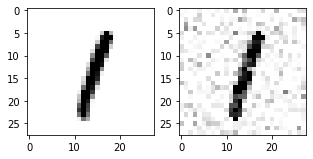

In [26]:
gaussian_noise = np.random.normal(0, 0.2, (28,28))
fig, ax = plt.subplots(1, 2,figsize=(5, 5))
ax[0].imshow(image, cmap='Greys')
ax[1].imshow(np.clip(image+gaussian_noise, 0.,1.), cmap='Greys')
plt.savefig(f"./gaussian_noise_{10000}", bbox_inches="tight")
plt.show()


# Decentralized Variance-Reduced Zeroth-Order FW

In [11]:
images = data[:1000]
targets = labels[:1000]
n = 5
S2 = 3
q = 5
S1 = len(images)
M = 10
T = 10
epsilon = 0.25
d = 784

308/308 [==============================] - 3s 11ms/step - loss: 0.5046 - accuracy: 0.8648


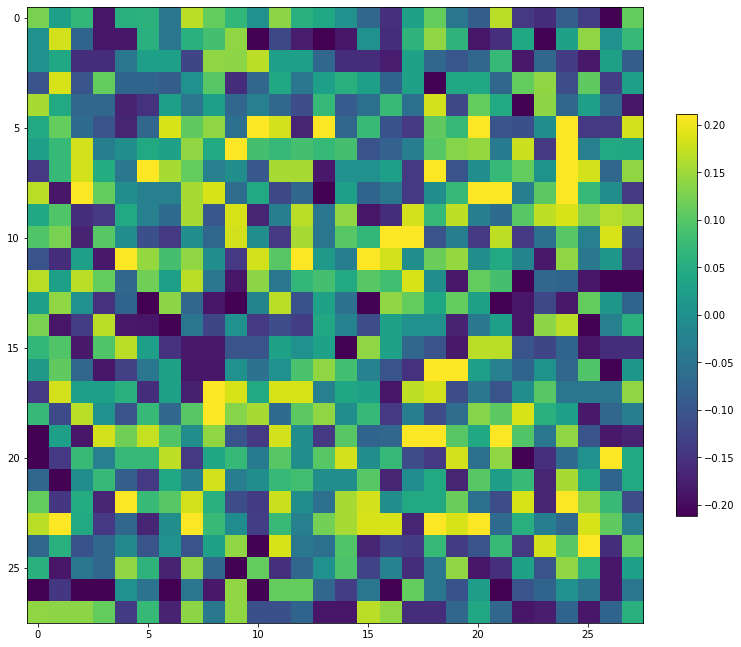

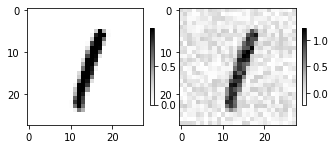

In [18]:
#delta = decentralized_variance_reduced_zo_FW(images, targets, lenet5.negative_loss, S2, T, M, n, epsilon, d, q, S1)
#np.save(f"./data/perturbation_variance", delta[-1])
delta = np.load(f"./data/perturbation_variance.npy")

perturbation = np.tile(delta, data.shape[0])
perturbation = perturbation.reshape((data.shape[0],28,28,1))
perturbated_data = data + perturbation
perturbated_data = np.clip(perturbated_data, 0., 1.)

loss = lenet5.model.evaluate(perturbated_data, labels)
plot_perturbation(delta, 10000)
plot_perturbated_img(delta, 10000)
#loss_history.append(loss)

# Distributed Zeroth-Order FW

9826
(10, 100, 28, 28, 1)
308/308 [==============================] - 2s 6ms/step - loss: 1.6253 - accuracy: 0.7277


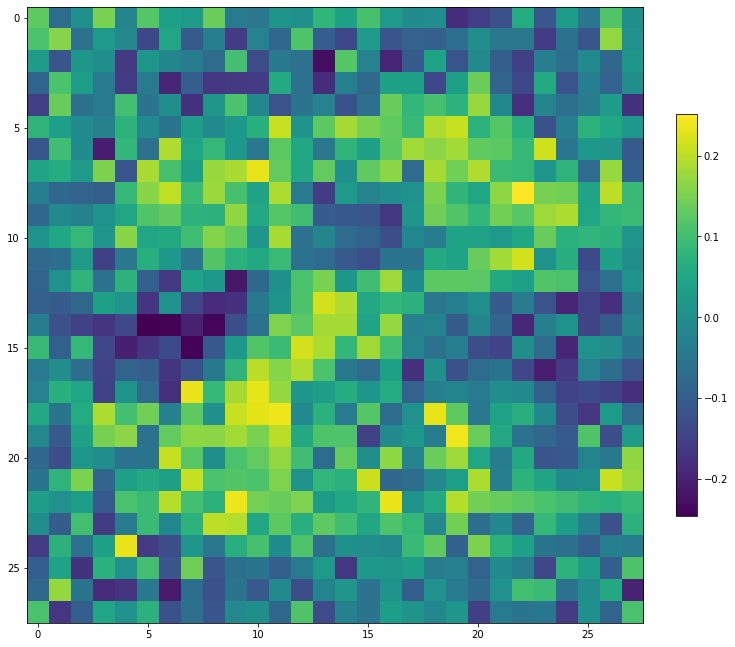

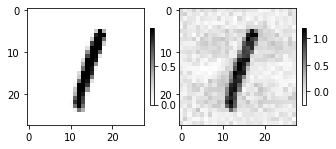

In [6]:
import utils
data_workers, y, lenet5, test_x, test_y, data, labels = utils.get_data()

T = 10
m = 20

delta_bar = np.load(f'../data/perturbations/distributed/distributed_delta_{T}_{m}.npy')
loss = []
for idx in range(delta_bar.shape[0]):
    delta = delta_bar[idx]
    perturbation = np.tile(delta, data.shape[0])
    perturbation = perturbation.reshape((data.shape[0],28,28,1))
    perturbated_data = data + perturbation
    perturbated_data = np.clip(perturbated_data, 0., 1.)
    loss.append(lenet5.model.evaluate(perturbated_data, labels)[0])
loss = np.array(loss)
delta_charming = delta_bar[np.argmax(loss)]

plot_perturbation(delta_charming, m)
plot_perturbated_img(delta_charming, m)

In [15]:
image = test_x[5].numpy().reshape(28,28)
img_noise = image + delta_charming.reshape((28, 28))
perturbated_data = np.clip(img_noise, 0., 1.)
print(lenet5.predict(np.array([perturbated_data.reshape(28, 28 ,1)])))

[8]
